# Introduction

In this notebook we use tools and techniques from fastai that we're already very familiar with to construct an image classifier. In the next notebook we'll tell a parallel story based on TensorFlow and its Keras API. 

# Setup

In [ ]:
%matplotlib inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2";

In [2]:
from fastai.vision.all import *

Set data dir:

In [3]:
with open('path.pkl', 'rb') as f:
    path = pickle.load(f)

In [4]:
path

Path('/home/alex/data/dat255/flower_photos')

In [5]:
path.ls()

(#9) [Path('/home/alex/data/dat255/flower_photos/flowers_dataset_train.tfrecord'),Path('/home/alex/data/dat255/flower_photos/flowers_dataset_test.tfrecord'),Path('/home/alex/data/dat255/flower_photos/flowers_dataset.tfrecord'),Path('/home/alex/data/dat255/flower_photos/roses'),Path('/home/alex/data/dat255/flower_photos/LICENSE.txt'),Path('/home/alex/data/dat255/flower_photos/dandelion'),Path('/home/alex/data/dat255/flower_photos/tulips'),Path('/home/alex/data/dat255/flower_photos/sunflowers'),Path('/home/alex/data/dat255/flower_photos/daisy')]

# Datablock and dataloaders

![](assets/datablock_api.png)

In [6]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [7]:
flowers = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(0.2),
                   get_y=parent_label,
                   item_tfms=RandomResizedCrop(600),
                   batch_tfms=[*aug_transforms(size=224), 
                               Normalize.from_stats(*imagenet_stats)])

In [8]:
flowers.summary(path)

Setting-up type transforms pipelines
Found 3670 items
2 datasets of sizes 2936,734
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/alex/data/dat255/flower_photos/dandelion/510677438_73e4b91c95_m.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=240x240
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /home/alex/data/dat255/flower_photos/dandelion/510677438_73e4b91c95_m.jpg
    applying parent_label gives
      dandelion
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(1)

Final sample: (PILImage mode=RGB size=240x240, TensorCategory(1))


Found 3670 items
2 datasets of sizes 2936,734
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': T

In [9]:
dls = flowers.dataloaders(path)

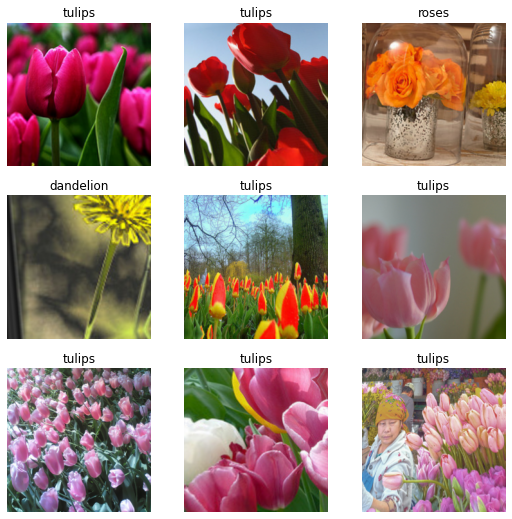

In [10]:
dls.show_batch()

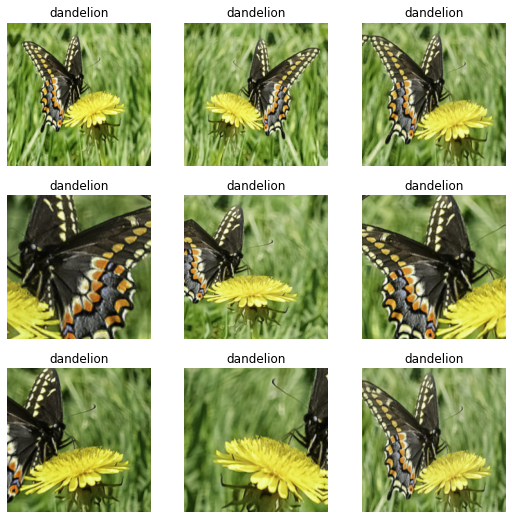

In [11]:
dls.show_batch(unique=True)

In [12]:
dls.vocab

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Train a model

In [13]:
learn = cnn_learner(dls, resnet18, pretrained=True, metrics=[accuracy, error_rate])

In [14]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

## Train only the head of the model

In [15]:
learn.freeze()

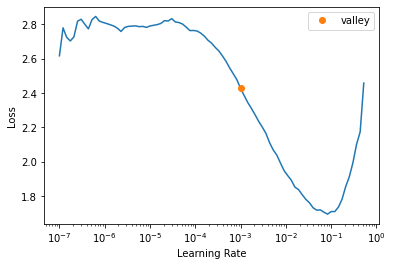

In [16]:
lr = learn.lr_find()

In [17]:
learn.fit_one_cycle(3, lr_max=slice(lr.valley))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.318699,0.351496,0.881471,0.118529,00:11
1,0.845809,0.297629,0.893733,0.106267,00:13
2,0.673027,0.290518,0.886921,0.113079,00:11


## Unfreeze and fine-tune the model

In [18]:
learn.unfreeze()

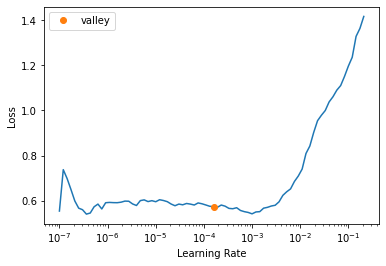

In [19]:
lr = learn.lr_find()

In [20]:
learn.fit_one_cycle(5, lr_max=slice(lr.valley))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.547136,0.269014,0.897820,0.102180,00:11
1,0.540315,0.249924,0.907357,0.092643,00:12
2,0.494666,0.220538,0.910082,0.089918,00:12
3,0.433917,0.220041,0.916894,0.083106,00:12
4,0.423044,0.220596,0.918256,0.081744,00:11


# Evaluate the model

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

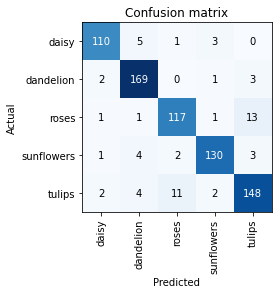

In [22]:
interp.plot_confusion_matrix()

In [23]:
# plot_top_losses function has a bug in fastai v. 2.5.3. 
# The below function is taken from 
# https://forums.fast.ai/t/plot-top-losses-problem/92015/12
def plot_top_losses_fix(interp, k, largest=True, **kwargs):
        losses,idx = interp.top_losses(k, largest)
        if not isinstance(interp.inputs, tuple): interp.inputs = (interp.inputs,)
        if isinstance(interp.inputs[0], Tensor): inps = tuple(o[idx] for o in interp.inputs)
        else: inps = interp.dl.create_batch(interp.dl.before_batch([tuple(o[i] for o in interp.inputs) for i in idx]))
        b = inps + tuple(o[idx] for o in (interp.targs if is_listy(interp.targs) else (interp.targs,)))
        x,y,its = interp.dl._pre_show_batch(b, max_n=k)
        b_out = inps + tuple(o[idx] for o in (interp.decoded if is_listy(interp.decoded) else (interp.decoded,)))
        x1,y1,outs = interp.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), interp.preds[idx], losses,  **kwargs)

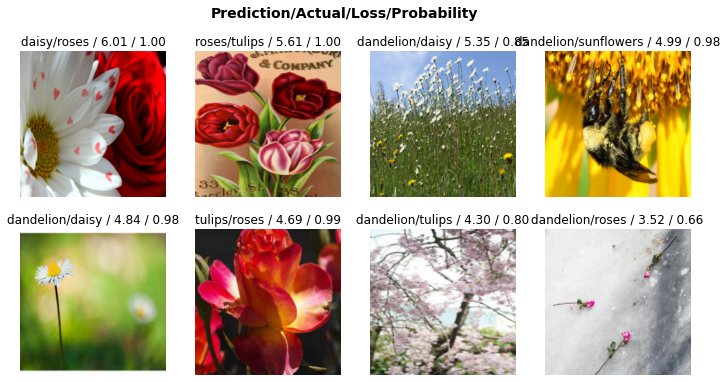

In [24]:
plot_top_losses_fix(interp, k=8)